# RuvB cycle ordering analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import MDS
import time
from os import listdir as ls

import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sympy.utilities.iterables import multiset_permutations

from scipy.optimize import minimize
from numba import jit

import warnings
warnings.filterwarnings('ignore')

import tools.load as load
import tools.spatial as spatial
import tools.sequence as seq
import tools.elastic as elastic

#print(rcParams.keys())

WIDTH = 3+3/8
TICK_SIZE = 6
FONT_SIZE = 8
LEGEND_SIZE = 6
TITLE_SIZE = 8

plt.rc("font", size = FONT_SIZE)
plt.rc("figure", titlesize = TITLE_SIZE)
plt.rc("xtick", labelsize = TICK_SIZE)
plt.rc("ytick", labelsize = TICK_SIZE)
plt.rc("axes", titlesize = TITLE_SIZE, labelsize = FONT_SIZE)
plt.rc("legend", fontsize = LEGEND_SIZE, frameon = False)

# Loading

We begin by loading the polypeptides for each RuvB hexamer and individual monomers

In [2]:
# Input
s_names = ['s1t2', 's2t2', 's3t2', 's4t2', 's5t2'] * 6
n = 5

# Set a vector to describe the chains names
chain_names = list(load.char_range('A','F'))[::-1]

# Compute
s_pps = []
for name in s_names:
    structure = load.single_structure(name, chain_ids=chain_names)        
    s_pps.append(structure)

# Compute monomers individually (only for RMSD analysis)
s_chains = []
for chain in chain_names:
    for i in range(n):
        structure = load.single_structure(s_names[i], chain_ids=chain)        
        s_chains.append(structure)

# Axis centering

Apply a rigid body rotation so that hexamers have chain F along the x-axis

In [4]:
xyz_r, labels = load.coordinates_all_atoms(s_pps[6])

# Indexes of chains' atoms
chain_idx = load.chain_indices(chain_names, labels)
chain_colors = ["tab:red", "tab:purple", "tab:blue", "tab:green", "tab:olive", "tab:orange"]
chain_colors = chain_colors[::-1]

# Center the geometric center on (0,0,0)
dsp = np.mean(xyz_r, 0)
spatial.rigid_body(s_pps[6], dsp, [0,0,0], [0,0,0])
xyz_r, labels = load.coordinates_all_atoms(s_pps[6])

# Chain F in leftmost position
rot_A = np.mean(xyz_r[chain_idx[0], :], 0)/2
rot_A[-1] = 0
spatial.rigid_body(s_pps[6], np.zeros(3), rot_A, [-1,0,0])
xyz_r, labels = load.coordinates_all_atoms(s_pps[6])

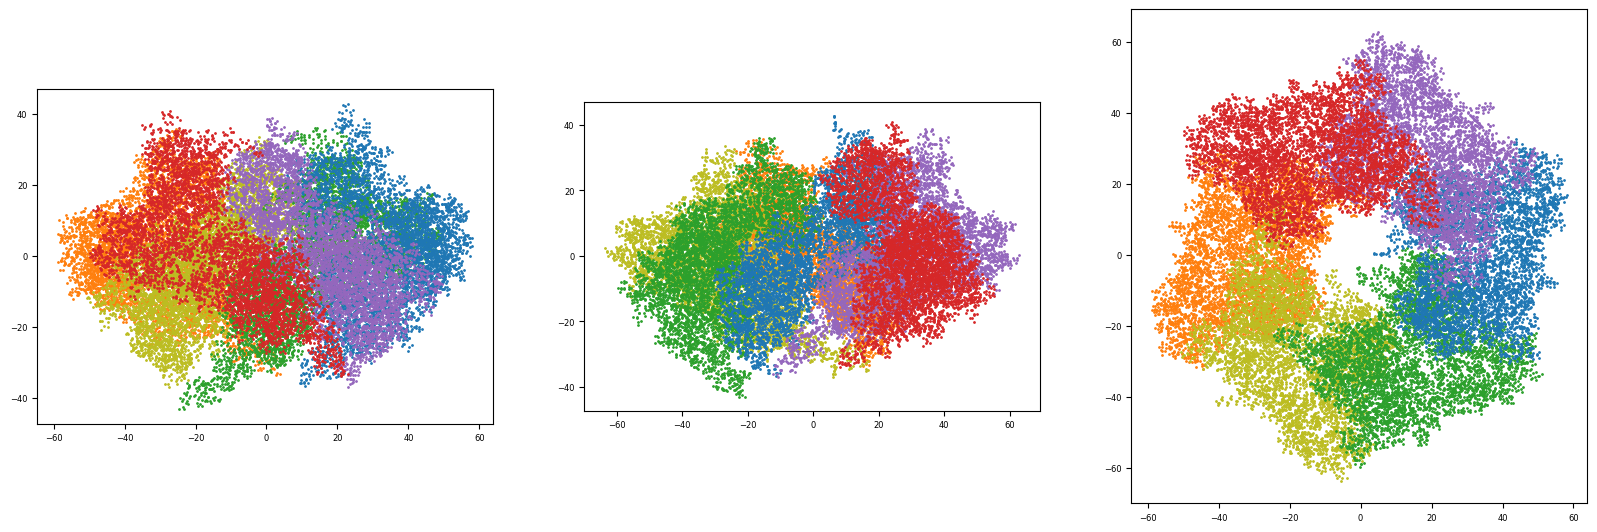

In [5]:
fig = plt.figure(figsize=(20, 10), dpi=100)
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

for idx, col in zip(chain_idx, chain_colors):
    xs, ys, zs = xyz_r[idx,0], xyz_r[idx,1], xyz_r[idx,2]

    ax1.scatter(xs, zs, s=1, color = col)
    ax2.scatter(ys, zs, s=1, color = col)
    ax3.scatter(xs, ys, s=1, color = col)

ax1.axis('scaled')
ax2.axis('scaled')
ax3.axis('scaled')
plt.show()

# Sequence alignments

We can verify that indeed the given chains are aligned by plotting their projections

In [6]:
# Input
uni_ids = [None] * len([s_pps[0][3]])
indexes = []
labels_hex = []
labels_mon = []
labels_hex_at = []
labels_mon_at = []

# Compute
my_ref_seqs = seq.generate_reference([s_pps[0][3]], uni_ids)
for i in range(len(s_pps)):
    temp = dict()
    temp_at = dict()
    for j in range(len(s_pps[i])):
        temp2 = seq.aligned_dict([s_pps[i][j]], seq.align([s_pps[i][j]], my_ref_seqs))
        temp2_at = seq.aligned_dict_all_atoms([s_pps[i][j]], seq.align([s_pps[i][j]], my_ref_seqs))
        
        temp.update(temp2)
        temp_at.update(temp2_at)
        
        labels_mon.append(temp2)
        labels_mon_at.append(temp2_at)
    labels_hex.append(temp)
    labels_hex_at.append(temp_at)

com_res = seq.common(labels_mon[0], labels_mon[2])
com_at = seq.common_multiple([labels_mon_at[i] for i in range(6)])

# Spatial alignments

In [7]:
# Aligning all hexamers to s1
for i in range(len(s_pps)):
    if i != 6:
        spatial.align_structures(s_pps[6], s_pps[i], 
                                 chain_names, com_res, 
                                 labels_hex[6], labels_hex[i],
                                 "atoms")
    
for i in range(len(s_pps)):
    theta = -(i//n) * np.pi/3
    spatial.rigid_body(s_pps[i], np.zeros(3), np.array([np.cos(theta), -np.sin(theta), 0]), [1,0,0])

for i in range(3*n, 4*n):
    spatial.rigid_body(s_pps[i], np.zeros(3), np.array([0, 1, 0]), [0, -1,0])

# Load coordinates of the atoms (backbone)

In [8]:
xyz = []
labels = []

for i in range(len(s_pps)):
    t1, t2 = load.coordinates_backbone(s_pps[i], com_at, labels_hex_at[i])
    xyz.append(t1)
    labels.append(t2)

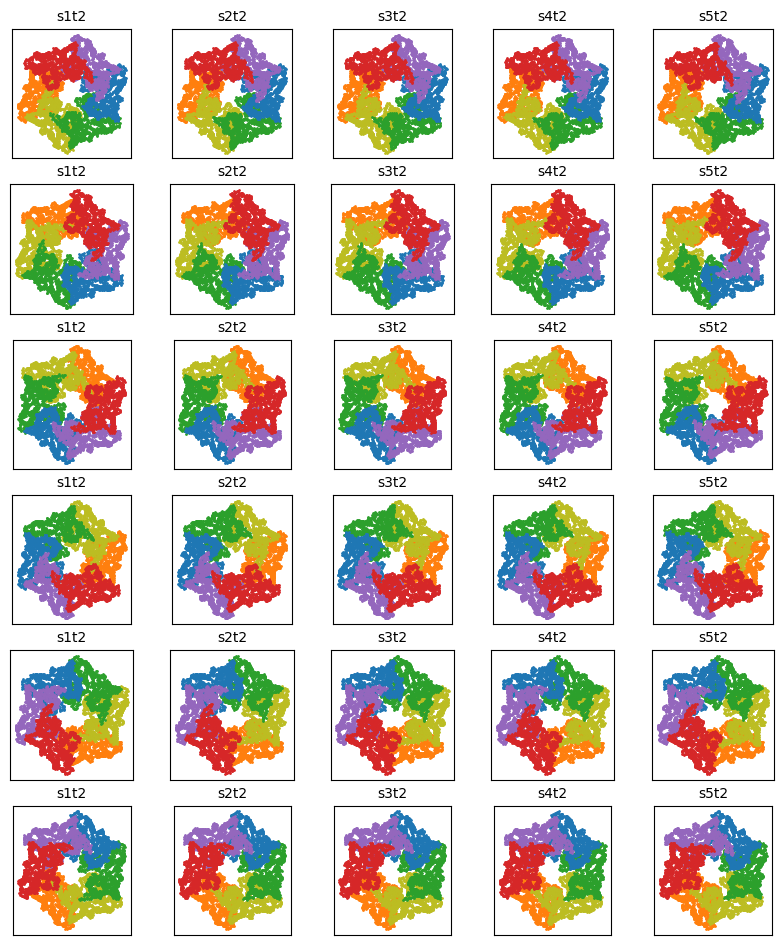

In [9]:
# Plot all structures
fig = plt.figure(figsize=(10, 12), dpi=100)

for i in range(len(s_pps)):
    ax = fig.add_subplot(6, n, i+1)
    structure = labels[i][0][0][0]
    ax.set_title(structure, size = 10)
    
    chain_idx = load.chain_indices(chain_names, labels[i])
    for idx, col in zip(chain_idx, chain_colors):
        xs, ys, zs = xyz[i][idx,0], xyz[i][idx,1], xyz[i][idx,2]
        ax.scatter(xs, ys, s=1, color = col)
    ax.axis('scaled')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

In [10]:
# Reorder the index to map the structures in the correct alignment
# Each chain now have 1/6 of the total aa
s = len(xyz[0])//6

for i in range(len(s_pps)-n):
    k = 1 + i//n
    
    reord2 = np.array(xyz[i][0:(6-k)*s], dtype = "object")
    reord1 = np.array(xyz[i][(6-k)*s:6*s], dtype = "object")

    xyz[i][0:k*s] = reord1
    xyz[i][k*s:6*s] = reord2
    
    reord2 = np.array(labels[i][0:(6-k)*s], dtype = "object")
    reord1 = np.array(labels[i][(6-k)*s:6*s], dtype = "object")

    labels[i][0:k*s] = reord1
    labels[i][k*s:6*s] = reord2
    

# Elasticity calculations

Using these coordinates, we compute the deformation gradients using the adequate weight function. These are intermediate quantities.

In [10]:
F = np.zeros((len(s_pps)**2, len(xyz[0]), 3, 3))
time1 = time.time()

c = 0

weights = elastic.avg_linear_weights_fulldata(xyz, parameters=[9.,9.01])

for i in range(len(s_pps)):
    for j in range(len(s_pps)): 
        
        structure_i = labels[i][0][0][0]
        chain_i = labels[i][0][0][2]
        
        structure_j = labels[j][0][0][0]
        chain_j = labels[j][0][0][2]  
        
        print("Computing def gradient for structures",
          structure_i, chain_i, "and",
           structure_j, chain_j)
        
        
        D, A = elastic.intermediate_matrixes(weights, xyz[i], xyz[j])
        F[c,:,:,:] = elastic.deformation_gradient(D, A)
        c+=1

time1 = time.time() - time1
print("Time:", time1)

Computing def gradient for structures s1t2 F and s1t2 F
Computing def gradient for structures s1t2 F and s2t2 F
Computing def gradient for structures s1t2 F and s3t2 F
Computing def gradient for structures s1t2 F and s4t2 F
Computing def gradient for structures s1t2 F and s5t2 F
Computing def gradient for structures s1t2 F and s1t2 E
Computing def gradient for structures s1t2 F and s2t2 E
Computing def gradient for structures s1t2 F and s3t2 E
Computing def gradient for structures s1t2 F and s4t2 E
Computing def gradient for structures s1t2 F and s5t2 E
Computing def gradient for structures s1t2 F and s1t2 D
Computing def gradient for structures s1t2 F and s2t2 D
Computing def gradient for structures s1t2 F and s3t2 D
Computing def gradient for structures s1t2 F and s4t2 D
Computing def gradient for structures s1t2 F and s5t2 D
Computing def gradient for structures s1t2 F and s1t2 C
Computing def gradient for structures s1t2 F and s2t2 C
Computing def gradient for structures s1t2 F and

Computing def gradient for structures s5t2 F and s3t2 A
Computing def gradient for structures s5t2 F and s4t2 A
Computing def gradient for structures s5t2 F and s5t2 A
Computing def gradient for structures s1t2 E and s1t2 F
Computing def gradient for structures s1t2 E and s2t2 F
Computing def gradient for structures s1t2 E and s3t2 F
Computing def gradient for structures s1t2 E and s4t2 F
Computing def gradient for structures s1t2 E and s5t2 F
Computing def gradient for structures s1t2 E and s1t2 E
Computing def gradient for structures s1t2 E and s2t2 E
Computing def gradient for structures s1t2 E and s3t2 E
Computing def gradient for structures s1t2 E and s4t2 E
Computing def gradient for structures s1t2 E and s5t2 E
Computing def gradient for structures s1t2 E and s1t2 D
Computing def gradient for structures s1t2 E and s2t2 D
Computing def gradient for structures s1t2 E and s3t2 D
Computing def gradient for structures s1t2 E and s4t2 D
Computing def gradient for structures s1t2 E and

Computing def gradient for structures s5t2 E and s5t2 B
Computing def gradient for structures s5t2 E and s1t2 A
Computing def gradient for structures s5t2 E and s2t2 A
Computing def gradient for structures s5t2 E and s3t2 A
Computing def gradient for structures s5t2 E and s4t2 A
Computing def gradient for structures s5t2 E and s5t2 A
Computing def gradient for structures s1t2 D and s1t2 F
Computing def gradient for structures s1t2 D and s2t2 F
Computing def gradient for structures s1t2 D and s3t2 F
Computing def gradient for structures s1t2 D and s4t2 F
Computing def gradient for structures s1t2 D and s5t2 F
Computing def gradient for structures s1t2 D and s1t2 E
Computing def gradient for structures s1t2 D and s2t2 E
Computing def gradient for structures s1t2 D and s3t2 E
Computing def gradient for structures s1t2 D and s4t2 E
Computing def gradient for structures s1t2 D and s5t2 E
Computing def gradient for structures s1t2 D and s1t2 D
Computing def gradient for structures s1t2 D and

Computing def gradient for structures s5t2 D and s2t2 B
Computing def gradient for structures s5t2 D and s3t2 B
Computing def gradient for structures s5t2 D and s4t2 B
Computing def gradient for structures s5t2 D and s5t2 B
Computing def gradient for structures s5t2 D and s1t2 A
Computing def gradient for structures s5t2 D and s2t2 A
Computing def gradient for structures s5t2 D and s3t2 A
Computing def gradient for structures s5t2 D and s4t2 A
Computing def gradient for structures s5t2 D and s5t2 A
Computing def gradient for structures s1t2 C and s1t2 F
Computing def gradient for structures s1t2 C and s2t2 F
Computing def gradient for structures s1t2 C and s3t2 F
Computing def gradient for structures s1t2 C and s4t2 F
Computing def gradient for structures s1t2 C and s5t2 F
Computing def gradient for structures s1t2 C and s1t2 E
Computing def gradient for structures s1t2 C and s2t2 E
Computing def gradient for structures s1t2 C and s3t2 E
Computing def gradient for structures s1t2 C and

Computing def gradient for structures s5t2 C and s4t2 C
Computing def gradient for structures s5t2 C and s5t2 C
Computing def gradient for structures s5t2 C and s1t2 B
Computing def gradient for structures s5t2 C and s2t2 B
Computing def gradient for structures s5t2 C and s3t2 B
Computing def gradient for structures s5t2 C and s4t2 B
Computing def gradient for structures s5t2 C and s5t2 B
Computing def gradient for structures s5t2 C and s1t2 A
Computing def gradient for structures s5t2 C and s2t2 A
Computing def gradient for structures s5t2 C and s3t2 A
Computing def gradient for structures s5t2 C and s4t2 A
Computing def gradient for structures s5t2 C and s5t2 A
Computing def gradient for structures s1t2 B and s1t2 F
Computing def gradient for structures s1t2 B and s2t2 F
Computing def gradient for structures s1t2 B and s3t2 F
Computing def gradient for structures s1t2 B and s4t2 F
Computing def gradient for structures s1t2 B and s5t2 F
Computing def gradient for structures s1t2 B and

Computing def gradient for structures s5t2 B and s1t2 C
Computing def gradient for structures s5t2 B and s2t2 C
Computing def gradient for structures s5t2 B and s3t2 C
Computing def gradient for structures s5t2 B and s4t2 C
Computing def gradient for structures s5t2 B and s5t2 C
Computing def gradient for structures s5t2 B and s1t2 B
Computing def gradient for structures s5t2 B and s2t2 B
Computing def gradient for structures s5t2 B and s3t2 B
Computing def gradient for structures s5t2 B and s4t2 B
Computing def gradient for structures s5t2 B and s5t2 B
Computing def gradient for structures s5t2 B and s1t2 A
Computing def gradient for structures s5t2 B and s2t2 A
Computing def gradient for structures s5t2 B and s3t2 A
Computing def gradient for structures s5t2 B and s4t2 A
Computing def gradient for structures s5t2 B and s5t2 A
Computing def gradient for structures s1t2 A and s1t2 F
Computing def gradient for structures s1t2 A and s2t2 F
Computing def gradient for structures s1t2 A and

Computing def gradient for structures s5t2 A and s3t2 D
Computing def gradient for structures s5t2 A and s4t2 D
Computing def gradient for structures s5t2 A and s5t2 D
Computing def gradient for structures s5t2 A and s1t2 C
Computing def gradient for structures s5t2 A and s2t2 C
Computing def gradient for structures s5t2 A and s3t2 C
Computing def gradient for structures s5t2 A and s4t2 C
Computing def gradient for structures s5t2 A and s5t2 C
Computing def gradient for structures s5t2 A and s1t2 B
Computing def gradient for structures s5t2 A and s2t2 B
Computing def gradient for structures s5t2 A and s3t2 B
Computing def gradient for structures s5t2 A and s4t2 B
Computing def gradient for structures s5t2 A and s5t2 B
Computing def gradient for structures s5t2 A and s1t2 A
Computing def gradient for structures s5t2 A and s2t2 A
Computing def gradient for structures s5t2 A and s3t2 A
Computing def gradient for structures s5t2 A and s4t2 A
Computing def gradient for structures s5t2 A and

# Principal stretches

We can now calculate, the rotations, the strain invariants, and the principal stretches

In [11]:
stretches = []

c = 0
time1 = time.time()
for i in range(len(s_pps)):
    for j in range(len(s_pps)):        
        gam_l, gam_n = elastic.lagrange_strain(F[c, 0:s])
        st, st_axis = elastic.principal_stretches_from_g(gam_n)
        stretches.append(st)
        
        c+=1

stretches = np.abs(stretches)**0.5        

a = np.sum((stretches**2-1)/2, axis = 2)**2
b = np.sum(((stretches**2-1)/2)**2, axis = 2)

lame_frst = 72976559.0446705 
lame_scnd = 37593984.96240601
psi = lame_frst/2 * a + lame_scnd * b


time1 = time.time() - time1
print("Time:", time1)

Time: 116.68535137176514


In [12]:
vdw = {"C":1.7e-10, "O":1.52e-10, "S":1.8e-10, "H":1.2e-10, "N":1.55e-10}
n_atom = {"C":0, "O":0, "S":0, "H":0, "N":0}
v_atom = {"C":0, "O":0, "S":0, "H":0, "N":0}

v = np.zeros(xyz[0].shape[0]//6)

for i in range(len(v)):
    at = labels[0][i][1]
    
    v[i] = 4*np.pi*vdw[at]**3/3
    n_atom[at] += 1
    v_atom[at] += v[i]

for at in list(vdw.keys()):
    print(at + ": n =", n_atom[at], "\tv =", v_atom[at], "\tvf =", v_atom[at]/np.sum(v))

C: n = 616 	v = 1.2676988186087048e-26 	vf = 0.5759103600740855
O: n = 308 	v = 4.530749901059044e-27 	vf = 0.20583010480267275
S: n = 0 	v = 0 	vf = 0.0
H: n = 0 	v = 0 	vf = 0.0
N: n = 308 	v = 4.804347586145464e-27 	vf = 0.21825953512323473


In [13]:
vol_dir = "data/volume/"
files = np.array(ls(vol_dir))


Vvdw = np.zeros(len(s_pps))

for i, name in enumerate(s_names):
    str_files = [file for file in files if name in file]
    
    chain = chain_names[i//5]
    str_ch_file = [file for file in str_files if "_" + chain in file][0]
    
    with open(vol_dir + str_ch_file, "r") as f:
        line = f.readlines()[8].split(" ")
        line = np.array(line)
        line = line[line != '']

        Vvdw[i] = float(line[3].replace(",", "."))*1e-30      

In [14]:
for i in range(psi.shape[0]):
    E2[i] = Vvdw[i // 30] * v * psi[i] / np.sum(v)

kT = 1.380649e-23*300
E2 /= kT

# Support functions

In [15]:
def plot_heatmap(data, digits = 2, fontsize = 15, ax = None, labels = True, 
                 colorbar = False, chainbar = False):
    
    data = data.copy(deep = True)
    
    if not ax:
        fig, ax = plt.subplots(figsize = (20,20))
    
    cmap = mpl.colormaps.get_cmap("Greys")
    im = ax.imshow(data, cmap)
    n = data.shape[0]

    states_names = []
    letters = chain_names
    for i in range(6):
        for j in range(n//6):
            states_names.append("s"+str(j+1)+letters[i])
    
    ax.xaxis.set_tick_params(labeltop = True, 
                             labelbottom = False,
                             top = True,
                             bottom = False)
        
    if labels:
        ax.set_xticks(range(n))
        ax.set_yticks(range(n))
        ax.set_xticklabels(states_names)
        ax.set_yticklabels(states_names)
    else:
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Loop over data dimensions and create text annotations.
    if fontsize != 0:
        for i in range(len(s_pps)):
            for j in range(len(s_pps)):
                text = ax.text(j, i, round(data.values[i, j], digits),
                               ha="center", va="center", color="w", size = fontsize)

    divider = make_axes_locatable(ax)
    axes = []
    
    if colorbar:
        colorbar_ax = divider.append_axes("bottom", pad = "5%", size = "5%")
        plt.colorbar(im, cax = colorbar_ax, orientation = "horizontal")
        axes.append(colorbar_ax)
    else:
        axes += [None]

    if chainbar:
        top_ax = divider.append_axes("top", pad = "2%", size = "4%")
        top_ax.bar(range(n), 1, width = 1, color = np.repeat(chain_colors, n//6))
        top_ax.set_xlim(-.5, n-.5)
        top_ax.set_xticks([])
        top_ax.set_yticks([])
        axes.append(top_ax)
        
        left_ax = divider.append_axes("left", pad = "2%", size = "4%")
        left_ax.barh(range(n), 1, height = 1, color = np.repeat(chain_colors[::-1], n//6))
        left_ax.set_ylim(-.5, n-.5)
        left_ax.set_xticks([])
        left_ax.set_yticks([])
        axes.append(left_ax)        
    else:
        axes += [None, None]
    
    return ax, axes

In [16]:
def fancy_scatter(ax, xdata, ydata, color, size, lw, alpha):
    ax.scatter(xdata, ydata, color = "black", s = size, lw = lw)
    ax.scatter(xdata, ydata, color = "white", s = size, lw = 0)
    ax.scatter(xdata, ydata, color = color, s = size, lw = 0, alpha = alpha)
    return

def plot_cycle(mds, nudge=0, title=""):
    fig, ax = plt.subplots(figsize=(4, 4), dpi = 300)
    ax.scatter(x = mds[:,0], y = mds[:,1], c = "white")

    for i in range(6):
        for j in range(n):
            ax.text(x = mds[i*n+j,0] + nudge, 
                    y = mds[i*n+j,1] + nudge, 
                    s = str(j), 
                    c = "black")

            ax.scatter(x = mds[i*n+j,0], 
                       y = mds[i*n+j,1], 
                       c = chain_colors[i],
                       s= 100)
    
    ax.set_title(title)
    ax.set_xlabel("MDS axis 1")
    ax.set_ylabel("MDS axis 2")

def plot_cycle2(mds, ax, title="", letters = True, s = 100, colors = True):
    ax.scatter(x = mds[:,0], y = mds[:,1], c = "white")
    
    for i in range(6):
        for j in range(n):
            if colors:
                c = chain_colors[i]
            else:
                c = "white"
                
            fancy_scatter(ax, 
                          mds[i*n+j,0],
                          mds[i*n+j,1],
                          c, s, 2, 1)
            
            
            if letters:
                ax.text(x = mds[i*n+j,0], 
                        y = mds[i*n+j,1], 
                        s = str(j+1), 
                        c = "black",
                        horizontalalignment = "center",
                        verticalalignment = "center")                
    
    ax.set_title(title)
    ax.set_xlabel("MDS axis 1")
    ax.set_ylabel("MDS axis 2")
    return

def plot_cycle3(mds, ax, alpha):
    ax.scatter(x = mds[:,:,0].flatten(), y = mds[:,:,1].flatten(), c = "white")
    
    
    for i in range(6):
        fancy_scatter(ax, 
                      mds[:, i*n+np.arange(n),0].flatten(),
                      mds[:, i*n+np.arange(n),1].flatten(),
                      chain_colors[i],
                      100, 0, alpha)
    return

In [17]:
def get_permutations():
    permutations = []
    for p in multiset_permutations(range(n)):
        permutations.append(tuple(p))
    
    return permutations

def get_distance(permutation, matrix):
    order = []
    for i in range(6):
        order += [j + n*i for j in permutation]
    
    order += [permutation[0]]
    
    dist = [sum((matrix[order[i], :] - matrix[order[(i+1)%len(order)], :])**2)**.5 for i in range(len(order))]
    dist = np.sum(dist)
    
    return dist

def get_all_distances(matrix):
    permutations = get_permutations()
    
    distances = dict()
    for p in permutations:
        distances[p] = get_distance(p, matrix)
    
    return dict(sorted(distances.items(), key=lambda item: item[1]))

def get_angle(permutation, matrix):
    order = []
    for i in range(6):
        order += [j + n*i for j in permutation]
    
    order += [permutation[0]]
    
    xyz = np.zeros((matrix.shape[0], 3))
    xyz[:, 0] = matrix[:, 0]
    xyz[:, 1] = matrix[:, 1]
    rtz = spatial.coordinates_to_polar(xyz)
    theta = rtz[:, 1]
    
    angle = [abs(theta[order[i]] - theta[order[(i+1)%len(order)]]) for i in range(len(order))]
    angle = sum(angle)
    
    return angle

def get_all_angles(matrix):
    permutations = get_permutations()
    
    angles = dict()
    for p in permutations:
        angles[p] = get_angle(p, matrix)
    
    return dict(sorted(angles.items(), key=lambda item: item[1]))


def is_order_correct(distances):
    orders = list(distances.keys())
    return sum([(orders[0][j] - j)**2 for j in range(n)]) == 0

state = range(0,6)


In [18]:
@jit(nopython=True)
def stress(xy_1d, data):
    n = len(xy_1d) // 2
    xy = np.zeros((n, 2))
    xy[:, 0] = xy_1d[n:]
    xy[:, 1] = xy_1d[:n]
    
    stress = 0
    for aa in range(data.shape[1]):
        c = 0
        for i in range(n):
            for j in range(n):
                stress += (data[c,aa] - np.sum((xy[i] - xy[j])**2)**0.5)**2
                c+=1
    stress = stress**0.5
    
    return stress

def my_mds(data, r):
    n = data.shape[0]
    np.random.seed(r)
    diss = np.array(data).flatten()[:, None]
    guess = (np.random.rand(2*n) - .5) * np.max(diss) * 10

    m = minimize(stress, guess, diss, method = "SLSQP")
    #m = minimize(stress, guess, diss, method = "BFGS")
    minimized_mds = np.zeros((n,2))
    minimized_mds[:, 0] = m.x[n:] - np.mean(m.x[n:])
    minimized_mds[:, 1] = m.x[:n] - np.mean(m.x[:n])
    return minimized_mds


# Calculating dissimilarity matrices

In [19]:
stretches_1 = pd.DataFrame(np.zeros((len(s_pps),len(s_pps))), index = s_names, columns = s_names)
stretches_2 = pd.DataFrame(np.zeros((len(s_pps),len(s_pps))), index = s_names, columns = s_names)
stretches_3 = pd.DataFrame(np.zeros((len(s_pps),len(s_pps))), index = s_names, columns = s_names)
energy = pd.DataFrame(np.zeros((len(s_pps),len(s_pps))), index = s_names, columns = s_names)

c = 0
for i in range(len(s_pps)):
    for j in range(len(s_pps)):
        a = np.array(stretches[c])
        stretches_1.values[i,j] = np.mean((a[:, 0]**2 - 1)/2)
        stretches_2.values[i,j] = np.mean((a[:, 1]**2 - 1)/2)
        stretches_3.values[i,j] = np.mean((a[:, 2]**2 - 1)/2)
        energy.values[i,j] = np.sum(E2[c])
        c+=1

# Dissimilarity matrix

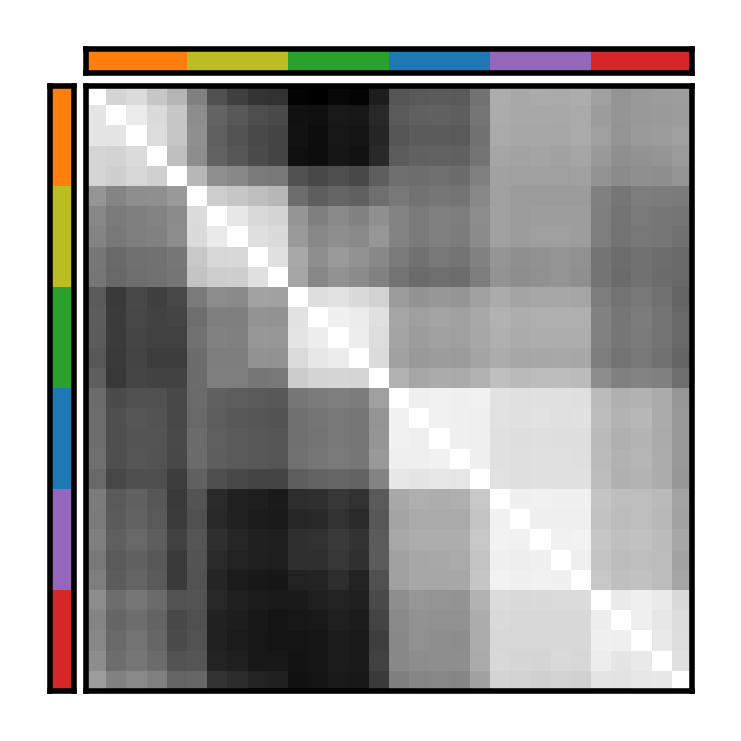

In [20]:
fig = plt.figure(figsize = (1.7, 1.7), dpi = 500)
ax = fig.add_subplot(1,1,1)
_, axes = plot_heatmap(stretches_3*100, digits = 2, 
                       fontsize = 0, ax = ax, 
                       labels = False, colorbar = False, chainbar = True)

plt.show()

# Symmetrised dissimilarity matrix

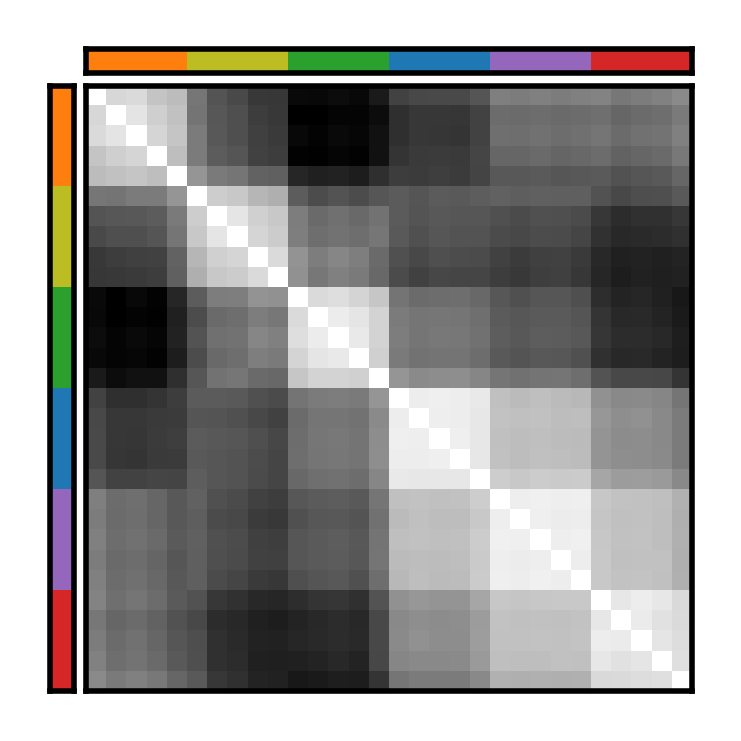

In [21]:
fig = plt.figure(figsize = (1.7, 1.7), dpi = 500)
ax = fig.add_subplot(1,1,1)
_, axes = plot_heatmap((stretches_3 + stretches_3.T)*50, digits = 2, 
                       fontsize = 0, ax = ax, 
                       labels = False, colorbar = False, chainbar = True)

plt.show()

# MDS for $\epsilon_3$

{(0, 1, 2, 3, 4): 76, (0, 2, 1, 3, 4): 24}
{(0, 1, 2, 3, 4): 72, (1, 2, 0, 3, 4): 19, (3, 2, 0, 1, 4): 5, (1, 0, 2, 3, 4): 3, (0, 2, 1, 3, 4): 1}


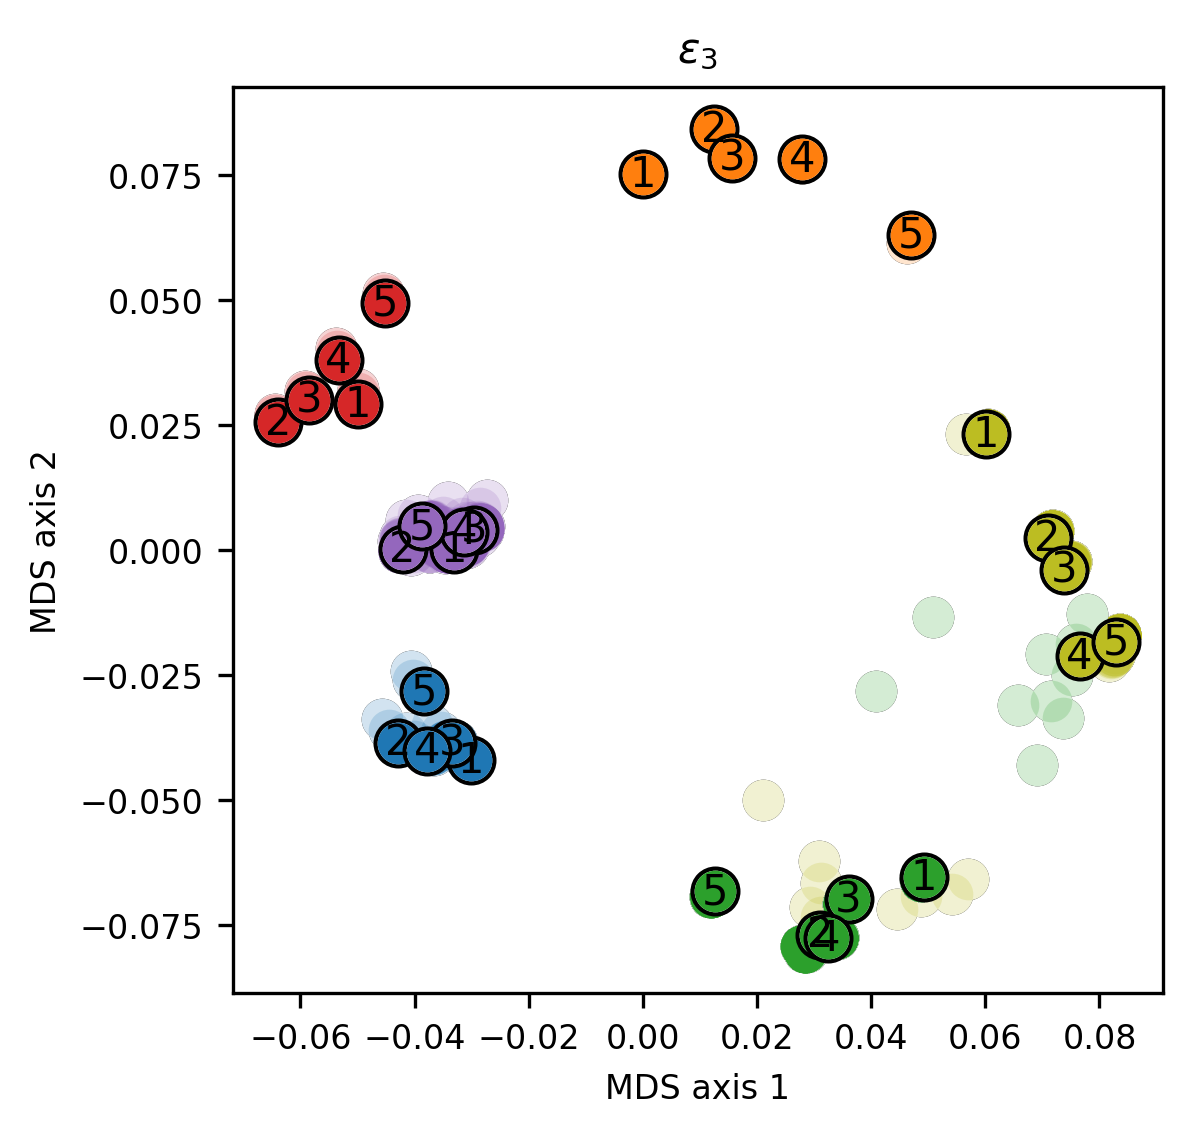

In [22]:
fig = plt.figure(figsize = (4,4), dpi = 300)
ax = fig.add_subplot(1,1,1)

st = stretches_3
sym_st = (st + st.T)/2

dist_list = []
angl_list = []

rep = 100
coords = np.zeros((rep, len(s_pps), 2))

for r in range(rep):
    #mds = MDS(2,random_state=r, dissimilarity = "precomputed")
    mds = my_mds(sym_st, r)
    
    x, y = mds[0]
    t = -np.arctan2(x, y)
    M = np.array([[np.cos(t), -np.sin(t)],
                  [np.sin(t), np.cos(t)]])
    
    mds = np.dot(mds, M)
    if mds[6, 0] < 0:
        mds[:, 0] *= -1
    
    coords[r] = mds
    
    dist = get_all_distances(mds)
    dist_list.append(list(dist.keys())[np.argmin(list(dist.values()))])
    
    angl = get_all_angles(mds)
    angl_list.append(list(angl.keys())[np.argmin(list(angl.values()))])
    
plot_cycle3(coords, ax, 0.2)
plot_cycle2(np.mean(coords, axis = 0), ax, "$\epsilon_3$", True)

best_dist = dict()
best_angl = dict()
for i, j in zip(dist_list, angl_list):
    if i in best_dist:
        best_dist[i] += 1
    else:
        best_dist[i] = 1
    if j in best_angl:
        best_angl[j] += 1
    else:
        best_angl[j] = 1
    
print(best_dist)
print(best_angl)

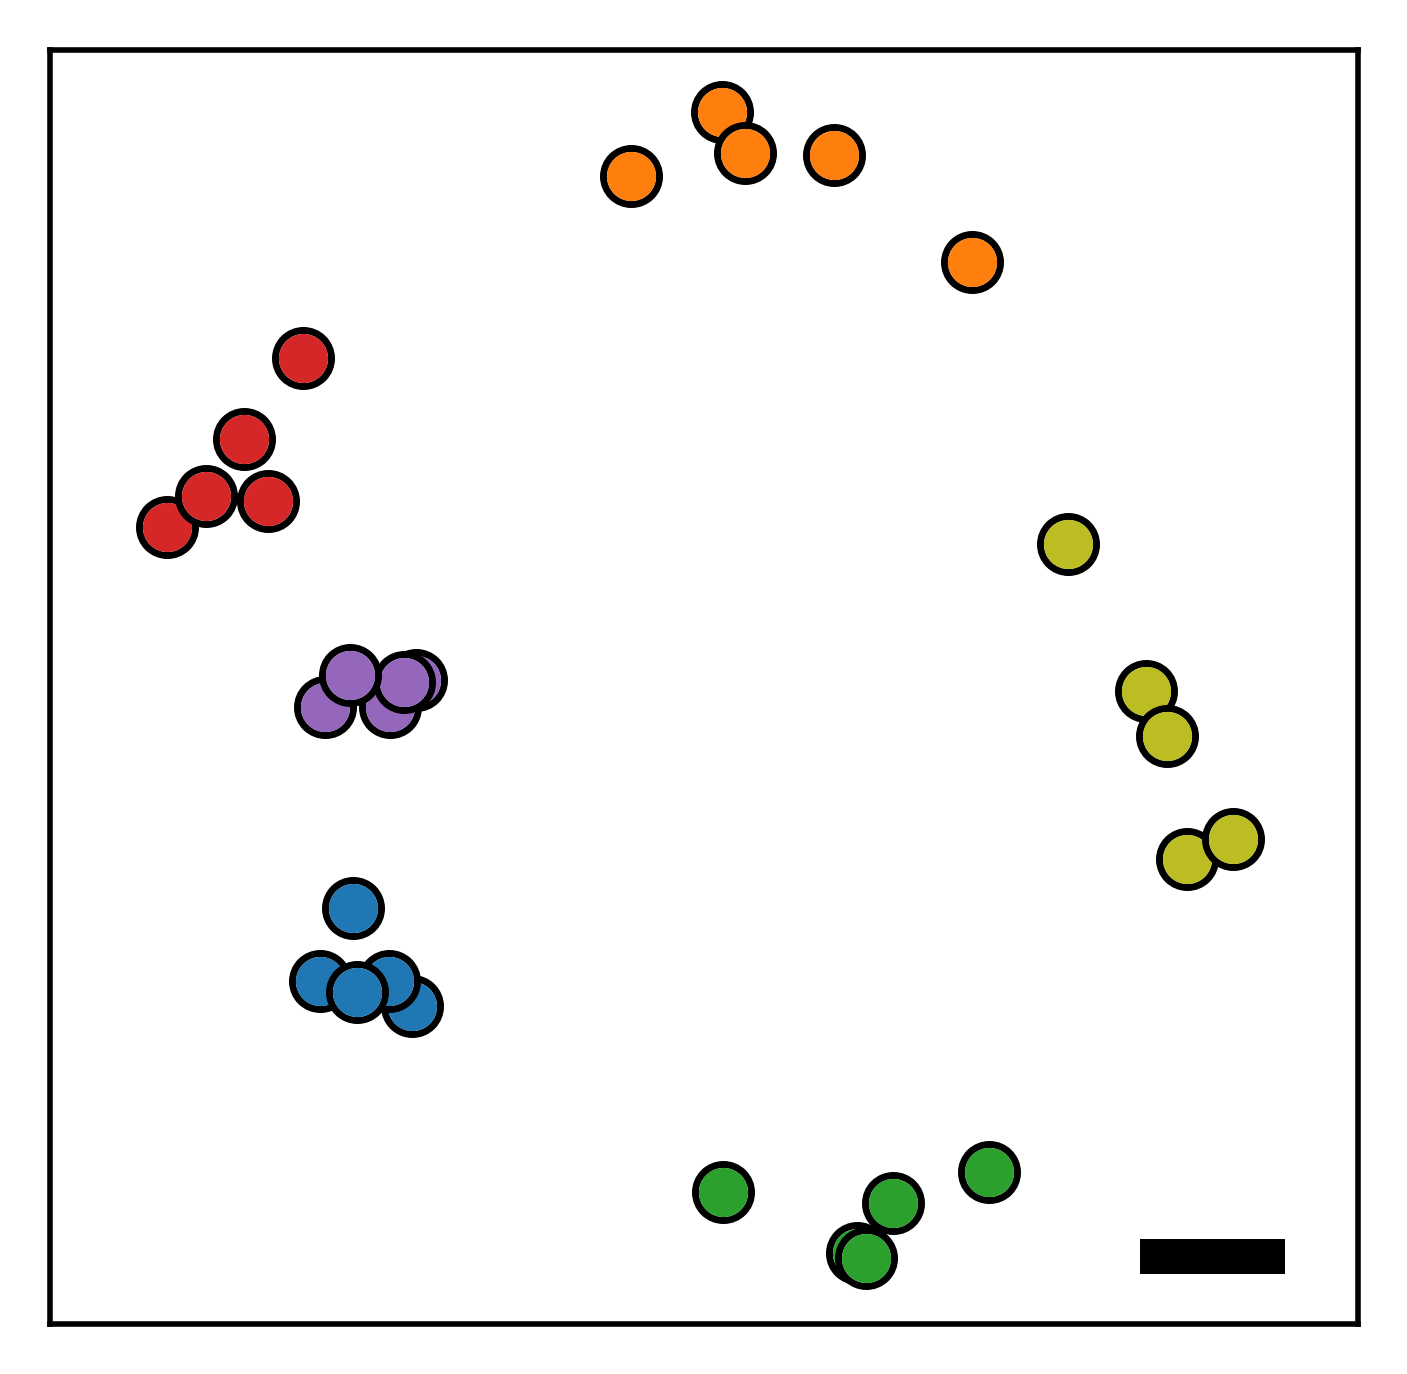

In [54]:
fig = plt.figure(figsize = (WIDTH, WIDTH), dpi = 500)
ax = fig.add_subplot(1,1,1)

plot_cycle2(np.mean(coords, axis = 0), ax, "", s = 50, letters = False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")

ax.bar(0.08, 0.005, 0.02, -0.08, color= "black")

d = 0.18
xl = -0.08
yb = -0.087
ax.set_xlim(xl, xl+d)
ax.set_ylim(yb, yb+d)


(-0.087, 0.093)

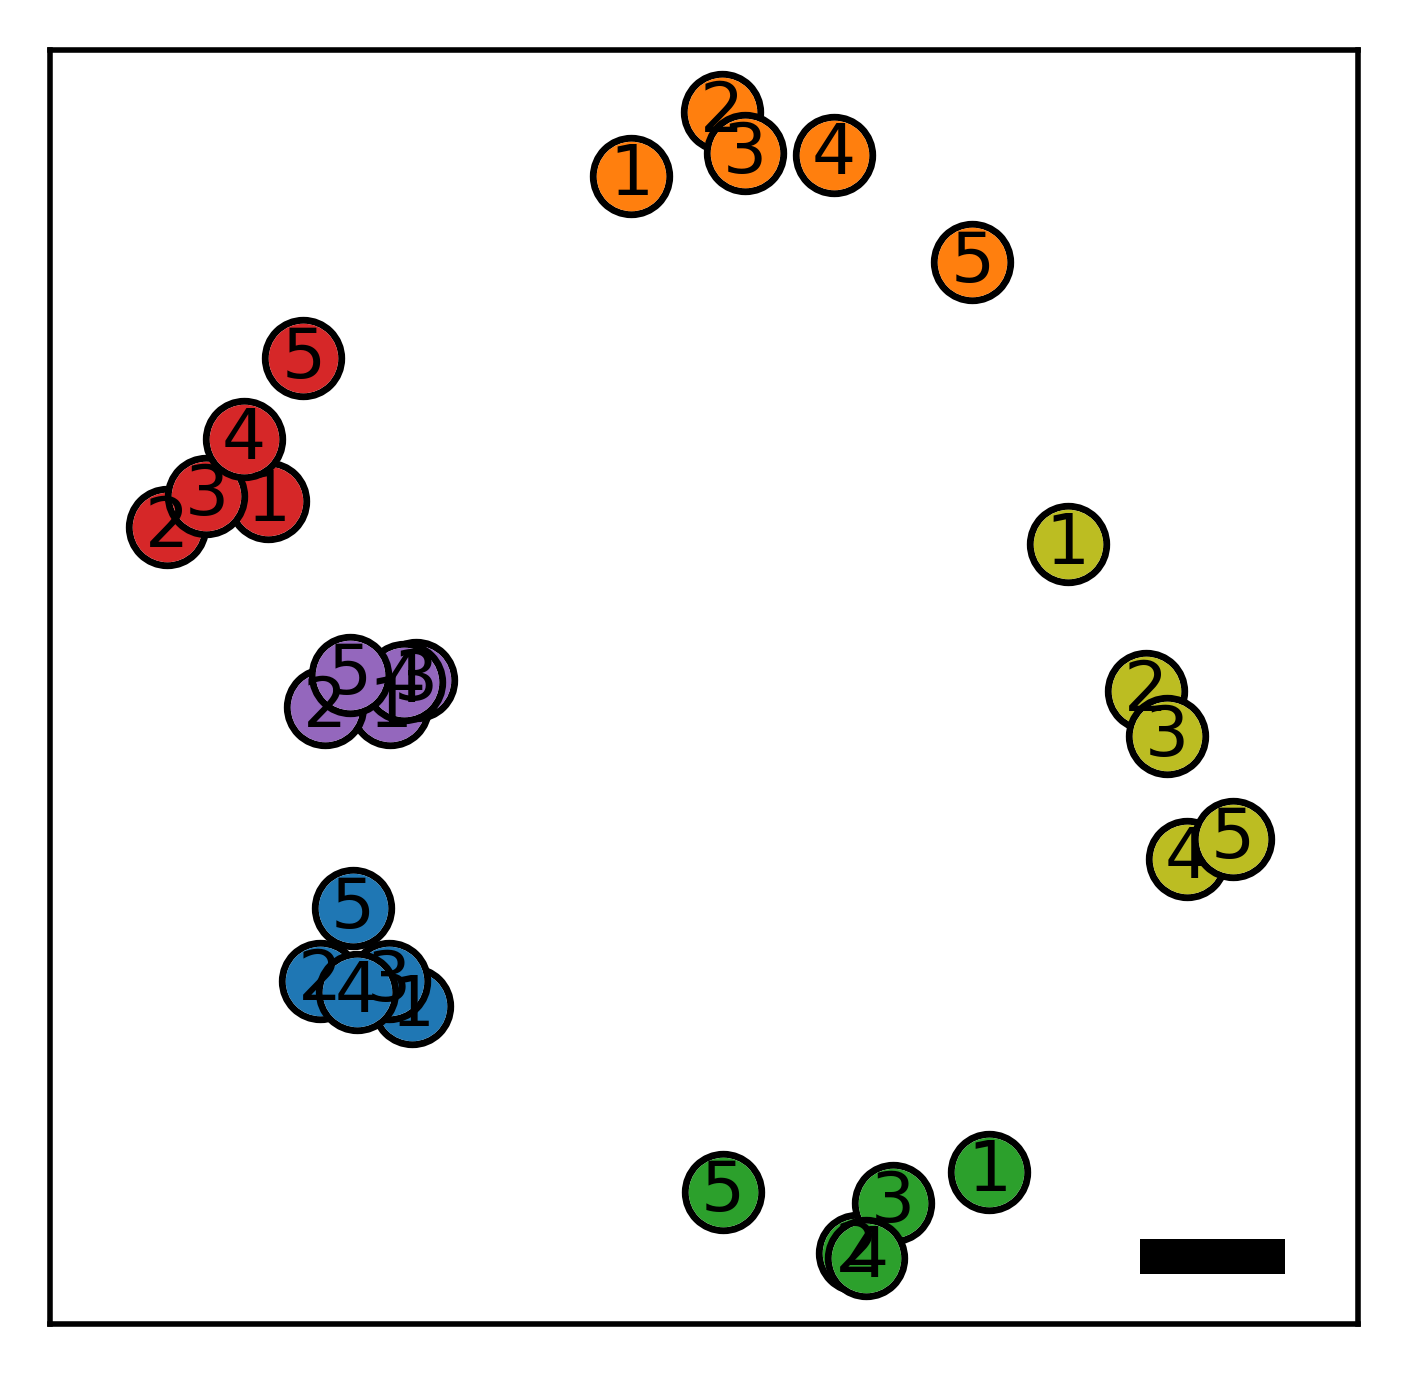

In [56]:
fig = plt.figure(figsize = (WIDTH, WIDTH), dpi = 500)
ax = fig.add_subplot(1,1,1)

plot_cycle2(np.mean(coords, axis = 0), ax, "", s = 100, letters = True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")

ax.bar(0.08, 0.005, 0.02, -0.08, color= "black")

d = 0.18
xl = -0.08
yb = -0.087
ax.set_xlim(xl, xl+d)
ax.set_ylim(yb, yb+d)


# MDS for $\epsilon_1$

{(0, 2, 1, 3, 4): 48, (0, 1, 2, 3, 4): 45, (2, 0, 1, 3, 4): 1, (1, 2, 3, 0, 4): 1, (0, 3, 2, 1, 4): 1, (0, 3, 1, 2, 4): 1, (1, 2, 0, 3, 4): 2, (0, 2, 1, 4, 3): 1}
{(0, 1, 2, 3, 4): 72, (1, 2, 0, 3, 4): 19, (3, 2, 0, 1, 4): 5, (1, 0, 2, 3, 4): 3, (0, 2, 1, 3, 4): 1}


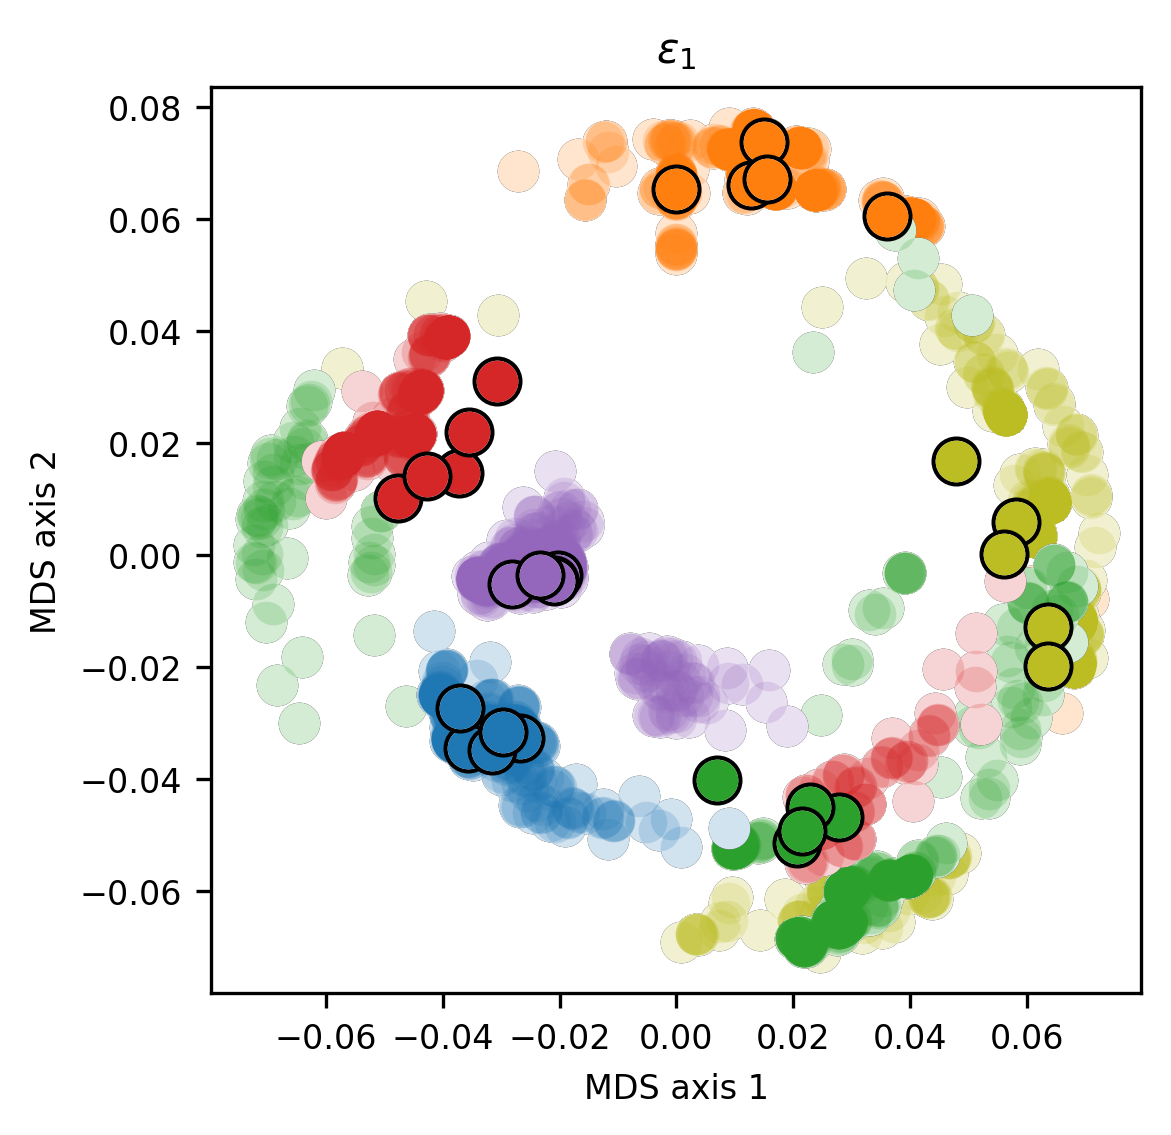

In [58]:
fig = plt.figure(figsize = (4,4), dpi = 300)
ax = fig.add_subplot(1,1,1)

st = -stretches_1
sym_st = (st + st.T)/2

dist_list = []

rep = 100
coords = np.zeros((rep, len(s_pps), 2))

for r in range(rep):
    #mds = MDS(2,random_state=r, dissimilarity = "precomputed")
    mds = my_mds(sym_st, r)
    
    x, y = mds[0]
    t = -np.arctan2(x, y)
    M = np.array([[np.cos(t), -np.sin(t)],
                  [np.sin(t), np.cos(t)]])
    
    mds = np.dot(mds, M)
    if mds[6, 0] < 0:
        mds[:, 0] *= -1
    
    coords[r] = mds
    
    dist = get_all_distances(mds)
    dist_list.append(list(dist.keys())[np.argmin(list(dist.values()))])
    
    angl = get_all_angles(mds)
    angl_list.append(list(angl.keys())[np.argmin(list(angl.values()))])

    
plot_cycle3(coords, ax, 0.2)
plot_cycle2(np.mean(coords, axis = 0), ax, "$\epsilon_1$", False)

    
best_dist = dict()
best_angl = dict()
for i, j in zip(dist_list, angl_list):
    if i in best_dist:
        best_dist[i] += 1
    else:
        best_dist[i] = 1
    if j in best_angl:
        best_angl[j] += 1
    else:
        best_angl[j] = 1
    
print(best_dist)
print(best_angl)

(-0.06, 0.08000000000000002)

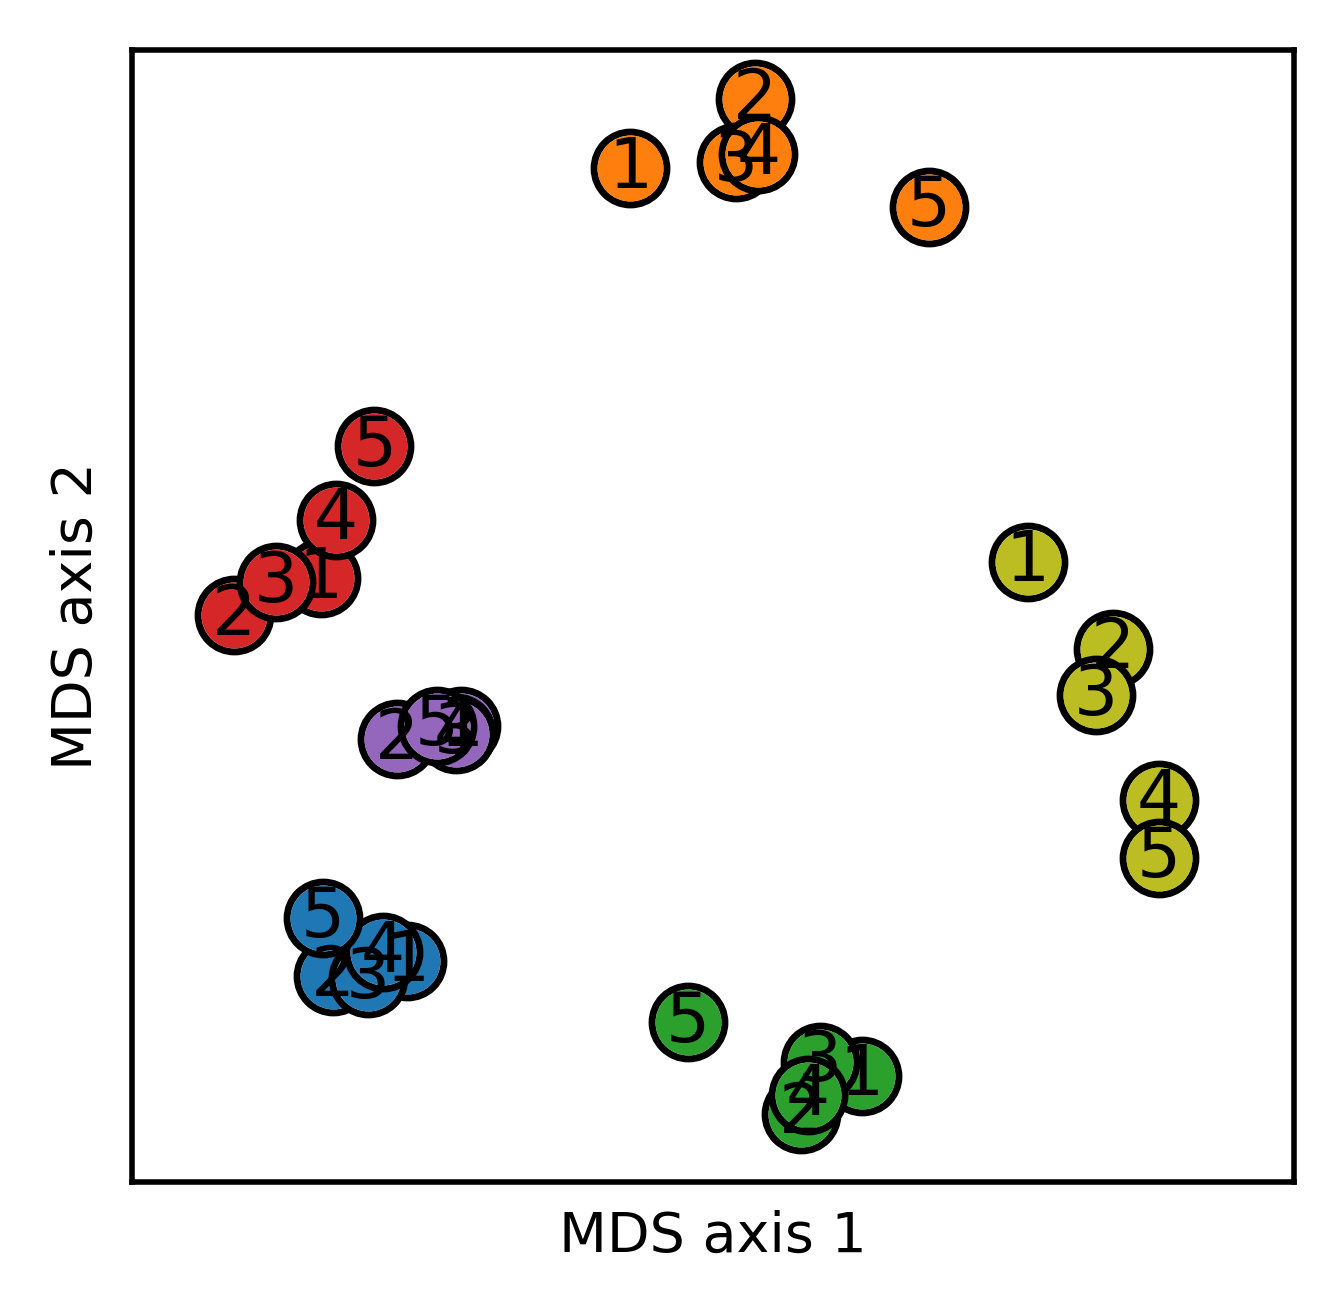

In [81]:
fig = plt.figure(figsize = (3, 3), dpi = 500)
ax = fig.add_subplot(1,1,1)

plot_cycle2(np.mean(coords, axis = 0), ax, "", True, 90)
ax.set_xticks([])
ax.set_yticks([])

d = 0.14
xl = -0.06
yb = -0.06
ax.set_xlim(xl, xl+d)
ax.set_ylim(yb, yb+d)

# MDS for elastic energy $E_{\rm el}$

{(0, 1, 2, 3, 4): 100}
{(0, 1, 2, 3, 4): 72, (1, 2, 0, 3, 4): 19, (3, 2, 0, 1, 4): 5, (1, 0, 2, 3, 4): 3, (0, 2, 1, 3, 4): 1}


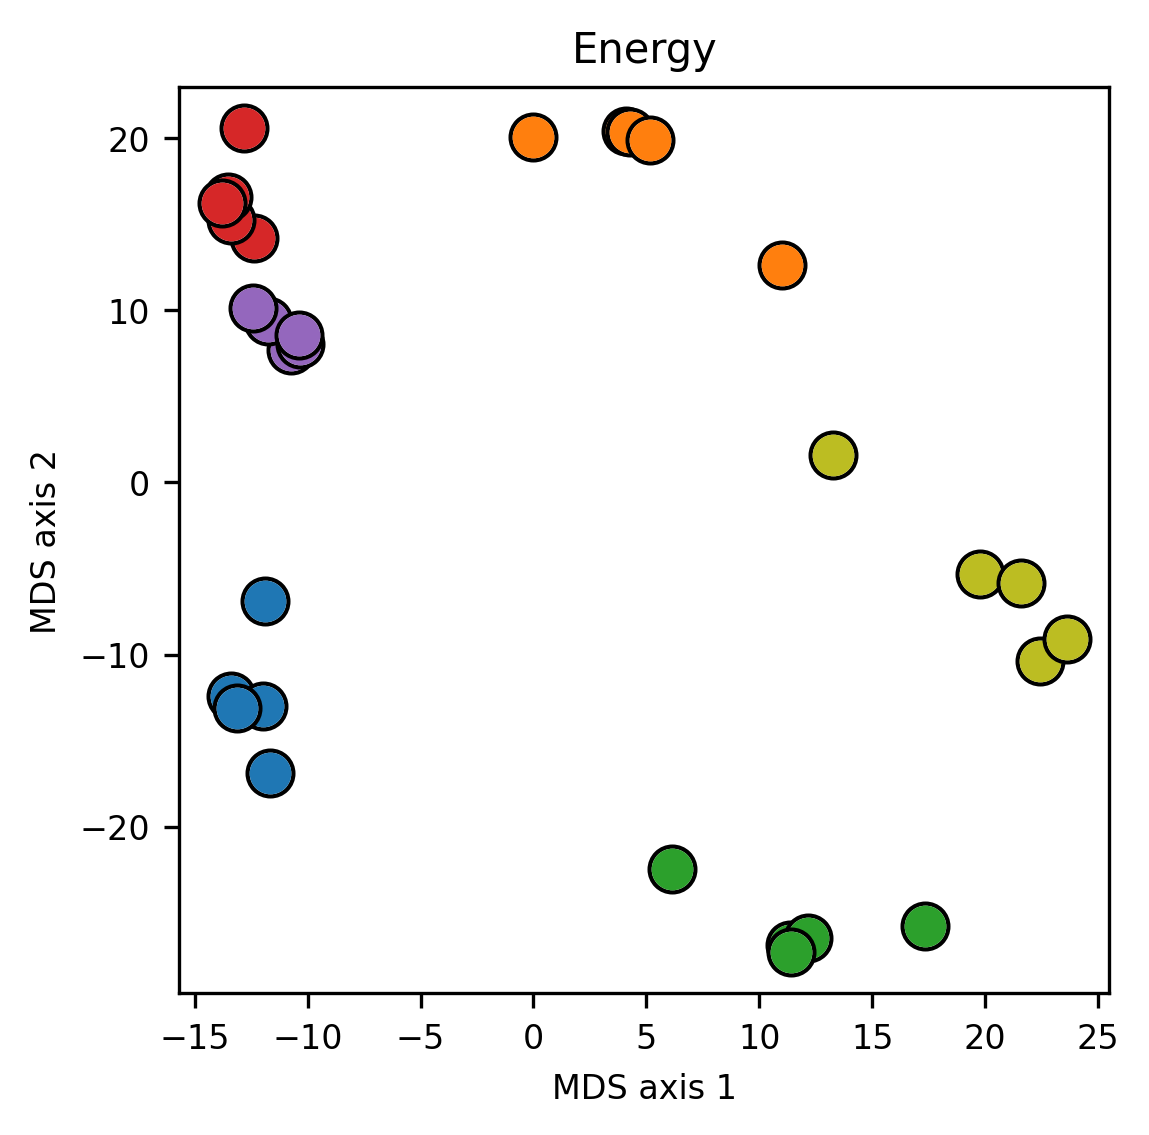

In [84]:
fig = plt.figure(figsize = (4,4), dpi = 300)
ax = fig.add_subplot(1,1,1)

st = np.abs(energy)
sym_st = (st + st.T)/2

dist_list = []

rep = 100
coords = np.zeros((rep, len(s_pps), 2))

for r in range(rep):
    #mds = MDS(2,random_state=r, dissimilarity = "precomputed")
    mds = my_mds(sym_st, r)
    
    x, y = mds[0]
    t = -np.arctan2(x, y)
    M = np.array([[np.cos(t), -np.sin(t)],
                  [np.sin(t), np.cos(t)]])
    
    mds = np.dot(mds, M)
    if mds[6, 0] < 0:
        mds[:, 0] *= -1
    
    coords[r] = mds
    
    dist = get_all_distances(mds)
    dist_list.append(list(dist.keys())[np.argmin(list(dist.values()))])
    
    angl = get_all_angles(mds)
    angl_list.append(list(angl.keys())[np.argmin(list(angl.values()))])

    
plot_cycle3(coords, ax, 0.2)
plot_cycle2(np.mean(coords, axis = 0), ax, "Energy", False)

best_dist = dict()
best_angl = dict()
for i, j in zip(dist_list, angl_list):
    if i in best_dist:
        best_dist[i] += 1
    else:
        best_dist[i] = 1
    if j in best_angl:
        best_angl[j] += 1
    else:
        best_angl[j] = 1
    
print(best_dist)
print(best_angl)

(-30.0, 25.0)

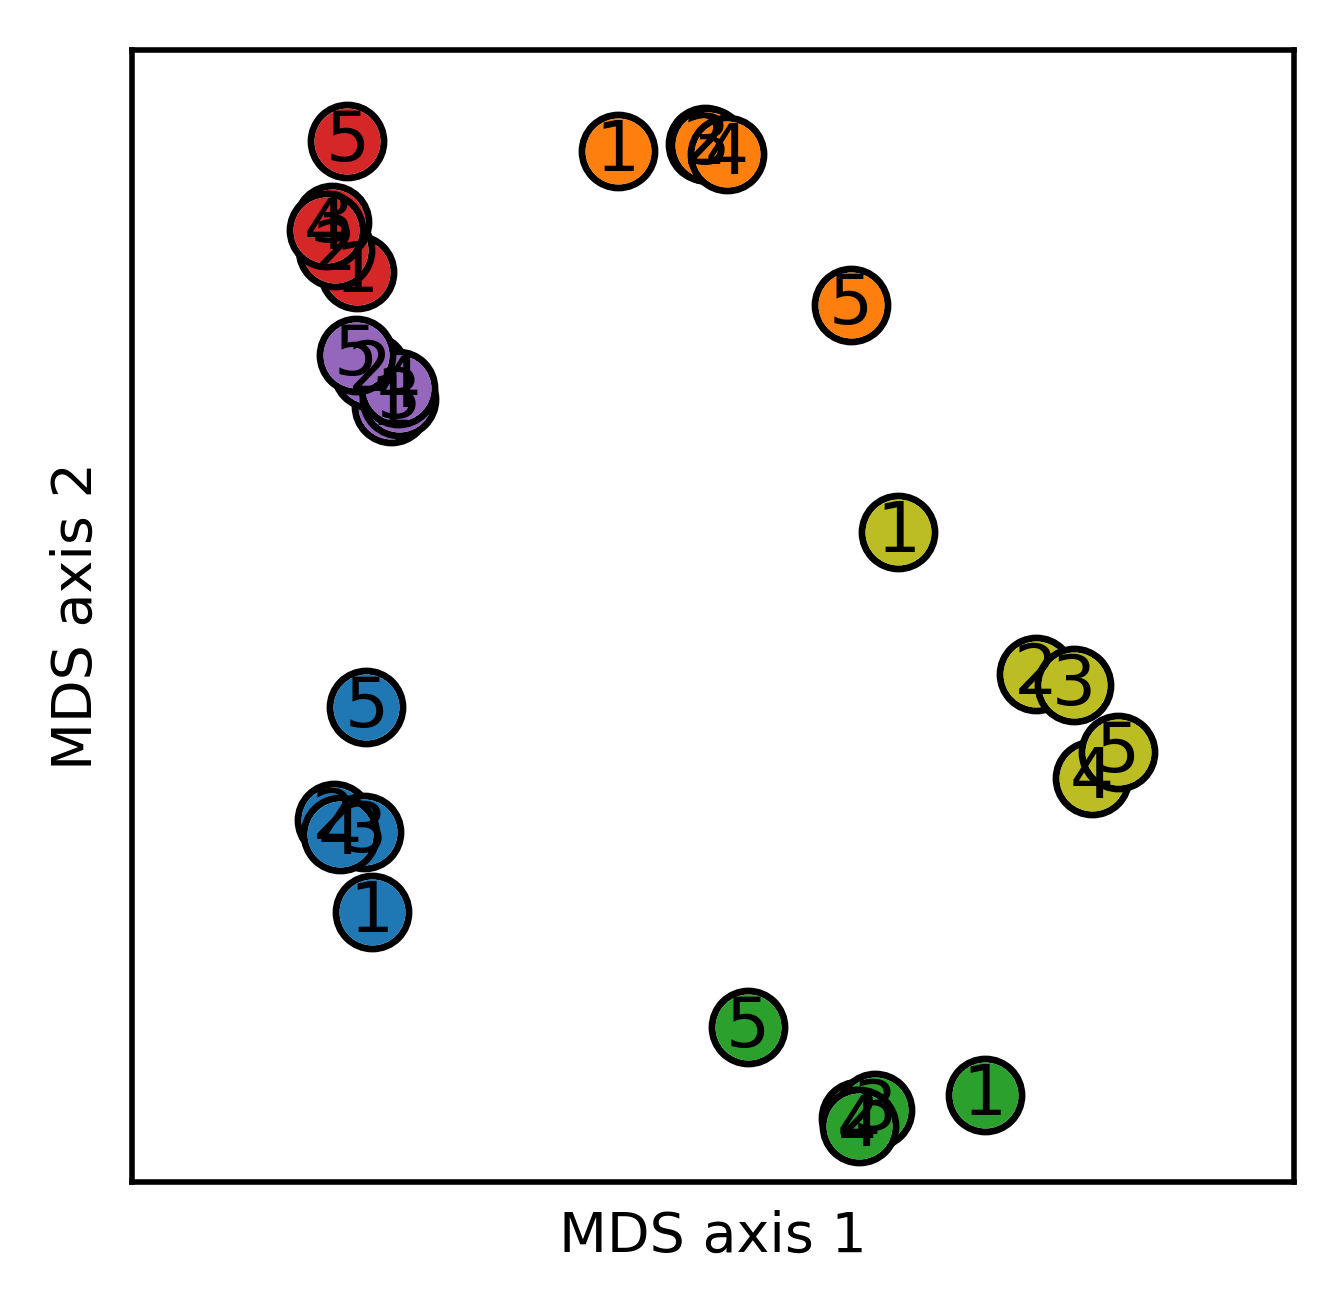

In [92]:
fig = plt.figure(figsize = (3, 3), dpi = 500)
ax = fig.add_subplot(1,1,1)

plot_cycle2(np.mean(coords, axis = 0), ax, "", True, 90)
ax.set_xticks([])
ax.set_yticks([])

d = 55
xl = -23
yb = -30
ax.set_xlim(xl, xl+d)
ax.set_ylim(yb, yb+d)